### 1. Import package 

In [1]:
import os, sys
sys.path.append('../src/')
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
import shap
from activityFeature_engineer import *
from pred_model import *
from AppAct_df import *

### ignore the warnings ###

/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2. Load data of app activities

In [2]:
data_dir = '../data/S3/AppEventData/'
CommunityMember, SubscriptionHistory, ActivityComplete, SessionCompleted, \
LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed = process_AppAct_df (data_dir)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


### 3. Sample trial users

##### 3.1 Remove Legacy/Hubspot and Administrator users

In [3]:
CommunityMember_filter = CommunityMember[CommunityMember['membershipName'] != 'Legacy']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Administrator']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Hubspot']
CommunityMember_filter_id = CommunityMember_filter.user.unique()
print (CommunityMember_filter[CommunityMember_filter['membershipSource']=='Unknown'].shape[0], \
       CommunityMember_filter[CommunityMember_filter['membershipSource']!='Unknown'].shape[0])

53009 2269


##### 3.2 Select users with purchase and users with free trials

In [4]:
SubscriptionHistory_purchase = SubscriptionHistory[SubscriptionHistory.event == 'subscription-purchase']
SubscriptionHistory_freeTrial = SubscriptionHistory[SubscriptionHistory.event == 'subscription-free-trial']
SubscriptionHistory_purchase_id = SubscriptionHistory_purchase.user.unique()
SubscriptionHistory_freeTrial_id = SubscriptionHistory_freeTrial.user.unique()
print (f'{len(SubscriptionHistory_purchase_id)} purchase users, {len(SubscriptionHistory_freeTrial_id)} trial users, \
{len(set(SubscriptionHistory_purchase_id).intersection(SubscriptionHistory_freeTrial_id))} intersected')

1559 purchase users, 1629 trial users, 712 intersected


##### 3.3 Select users with purchase converted from trial

In [5]:
convertedFromTrial_id = SubscriptionHistory[SubscriptionHistory.convertedFromTrial == bool('True')].user.unique()
nonconverted_trial = set(SubscriptionHistory_freeTrial_id).difference(SubscriptionHistory_purchase_id)
converted_trial = set(SubscriptionHistory_freeTrial_id).intersection(SubscriptionHistory_purchase_id).intersection(convertedFromTrial_id)
print (f'{len(nonconverted_trial)} nonconverted trial users, {len(converted_trial)} converted trial users')

917 nonconverted trial users, 707 converted trial users


##### 3.4 Select trial users that are not Legacy/Hubspot/Admin

In [6]:
nonconverted = nonconverted_trial.intersection(CommunityMember_filter_id)
converted = converted_trial.intersection(CommunityMember_filter_id)
print (f'Filtering the Legacy and Admin users: {len(nonconverted)} nonconverted, {len(converted)} converted')
IDs = list(nonconverted) + list(converted)

Filtering the Legacy and Admin users: 864 nonconverted, 698 converted


### 4. EDA: How many days before trials?

Users that created an account before trial
          days_create2Trial
                      count
Converted                  
False                   202
True                    316 

The number of days before trial of these users 
 X-axis = number of days before trials 
 y-axis = freq
[<AxesSubplot:title={'center':'False'}>
 <AxesSubplot:title={'center':'True'}>]


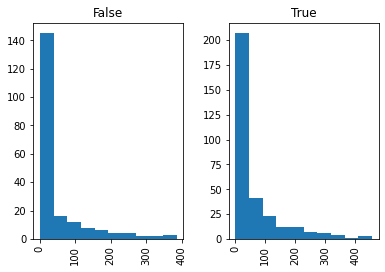

In [7]:
b4Trial_dict = {}
for ID in IDs:
    trial_start = pd.to_datetime(SubscriptionHistory[(SubscriptionHistory['user']==ID)&(SubscriptionHistory['event']=='subscription-free-trial')]['eventDate'].values)
    create_date = pd.to_datetime(CommunityMember[(CommunityMember['user']==ID)]['createdAt'].values)
    b4Trial_dict[ID] = (trial_start-create_date).days.values[0]
    
b4Trial_df = pd.DataFrame(list(b4Trial_dict.items()), columns = ['user', 'days_create2Trial']).set_index(['user'])
b4Trial_df['Converted'] = bool(True)
b4Trial_df.loc[list(nonconverted), 'Converted'] =  bool(False)

# print ('Trial users whose subscribe before creation date')
# print (b4Trial_df[b4Trial_df.days_create2Trial < 0])

b4Trial_filter = b4Trial_df[(b4Trial_df.days_create2Trial > 0)]
print ('Users that created an account before trial')
print (b4Trial_filter.groupby(['Converted']).agg(['count']), '\n')

print ('The number of days before trial of these users \n X-axis = number of days before trials \n y-axis = freq')
print (b4Trial_filter.days_create2Trial.hist(by=b4Trial_filter.Converted))

## 5. Feature engineering

In [8]:
# During trial: freq, cons
DFs = ActivityComplete, SessionCompleted, LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed
trial_activity = feature_duration(DFs, IDs, SubscriptionHistory)

In [9]:
# During first 2 days of trial: freq
DFs = trial_activity['ActivityComplete']['filter'], trial_activity['SessionCompleted']['filter'], \
trial_activity['LibrarySelectedTab']['filter'], trial_activity['ScreenViewed']['filter'], \
trial_activity['AppForeground']['filter'], trial_activity['SessionViewed']['filter']
trial2_activity = feature_duration(DFs, IDs, SubscriptionHistory, duration = 3, consecutive = False)

In [10]:
# Before trial: freq, daily ave, norm
DFs = ActivityComplete, SessionCompleted, LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed
b4_activity = feature_duration(DFs, IDs, SubscriptionHistory, add = False, consecutive = False, cal_ave = True, dayDF = b4Trial_filter)

In [11]:
# 7 days before and 7 days during trial: cons
DFs = pd.concat([trial_activity['ActivityComplete']['filter'], b4_activity['ActivityComplete']['filter']]), \
pd.concat([trial_activity['SessionCompleted']['filter'], b4_activity['SessionCompleted']['filter']]), \
pd.concat([trial_activity['LibrarySelectedTab']['filter'], b4_activity['LibrarySelectedTab']['filter']]), \
pd.concat([trial_activity['ScreenViewed']['filter'], b4_activity['ScreenViewed']['filter']]), \
pd.concat([trial_activity['AppForeground']['filter'], b4_activity['AppForeground']['filter']]), \
pd.concat([trial_activity['SessionViewed']['filter'], b4_activity['SessionViewed']['filter']])

b4_duringTrial_activity = feature_duration(DFs, IDs, SubscriptionHistory, filter = False, freq = False)

## 6. Feature dataframe
Column 'Converted': True = converted, False = nonconverted 

In [12]:
# Converted/Churned Trial Users - Select users that do not have ambiguous days before trial
feature_df = b4Trial_df[(b4Trial_df.days_create2Trial >= 0)]

In [13]:
# Features: Goal & Experience
CommunityMember_join = CommunityMember[['user','goal', 'exp']].set_index('user')
feature_df = feature_df.join(CommunityMember_join)
feature_df = feature_df[feature_df.goal.notnull()]
feature_df = feature_df[feature_df.exp.notnull()]
# one hot encoding
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['goal'], prefix='goal')],axis=1)
feature_df.drop(['goal'],axis=1, inplace=True)
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['exp'], prefix='exp')],axis=1)
feature_df.drop(['exp'],axis=1, inplace=True)

In [15]:
# Append app activity features
def append_feature_df (feature, pre_column, renamed_column, feature_df):
    feature_renamed = feature.rename(columns={pre_column:renamed_column})
    feature_df_new = feature_df.join(feature_renamed[renamed_column])
    return feature_df_new
    
def iterate_feature_type (df, df_name, feature_df, feature_types= [('norm', 'normed_daily_ave'), \
('cons', 'number_consecutive_day'), ('ave', 'daily_ave'), ('freq', 'count')]):
    for activity_name in df:
        for metrics, metric_name in feature_types:
            try:
                feature = df[activity_name][metrics]
                new_name = df_name+'_'+ activity_name+'_'+metrics
                feature_df = append_feature_df (feature, metric_name, new_name, feature_df)
            except:
                pass
    return feature_df
            
feature_df_new = iterate_feature_type (b4_activity, 'b4Trial', feature_df)
feature_df_new = iterate_feature_type (trial_activity, '7dTrial', feature_df_new)
feature_df_new = iterate_feature_type (trial2_activity, '2dTrial', feature_df_new)
feature_df_new = iterate_feature_type (b4_duringTrial_activity, 'b4_duringTrial', feature_df_new)

feature_df_new = feature_df_new.fillna(0)
feature_df_new.shape

(1551, 51)

## 7. Model selection and tuning

In [81]:
# define datasets
X = feature_df_new.loc[:,feature_df_new.columns!='Converted']
y = feature_df_new['Converted']
try:
    X_p= pd.read_csv('../results/X', index_col='user')
    X = X.loc[X_p.index,:] # to reproduce the same indexed dataframe
except:
    pass
X = X.astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### 5-fold cross validation, accompanied with Recursive Feature Elimination 

>Decision Tree 0.604 (0.023)
>Logistic Regression 0.644 (0.017)
>Random Forest 0.669 (0.016)
>XG Boost 0.653 (0.025)


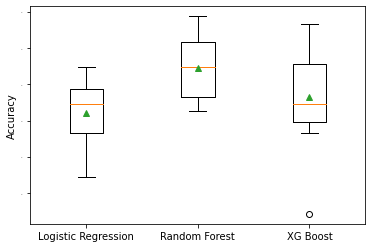

In [84]:
def get_models():
	models = dict()
    # decision tree
	rfe = RFECV(estimator=DecisionTreeClassifier())
	model = DecisionTreeClassifier()
	models['Decision Tree'] = Pipeline(steps=[('s',rfe),('m',model)])
    # lr
	rfe = RFECV(estimator=LogisticRegression())
	model = LogisticRegression()
	models['Logistic Regression'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFECV(estimator=RandomForestClassifier())
	model = RandomForestClassifier()
	models['Random Forest'] = Pipeline(steps=[('s',rfe),('m',model)])
    # XGB
	rfe = RFECV(estimator=XGBClassifier())
	model = XGBClassifier()
	models['XG Boost'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
plt.boxplot(results[1:4], labels=names[1:4], showmeans=True)
plt.ylabel('Accuracy', fontsize = 10)
plt.xticks(fontsize = 10)
plt.savefig('../results/RFECV_models.png', dpi = 400, transparent = True)
plt.show()

##### Grid search for hyperparameters

F1 score: 0.5983606557377049
accuracy: 0.684887459807074
Confusion Matrix
[[140  25]
 [ 73  73]]


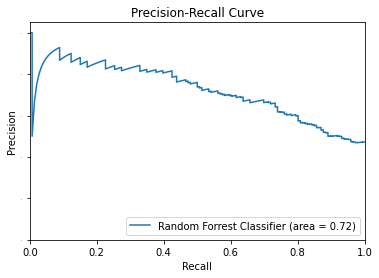

In [86]:
# baseline model without Recursive feature elimination
rfc=RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
baseline_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
baseline_rfc.fit(X_train, y_train)
y_pred_baseline = baseline_rfc.predict(X_test)
print ('best parameter: ', baseline_rfc.best_params_)
plot_AUC(baseline_rfc, X_test, y_test)

best parameter:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}
48 selected features
F1 score: 0.6065573770491803
accuracy: 0.6913183279742765
Confusion Matrix
[[141  24]
 [ 72  74]]


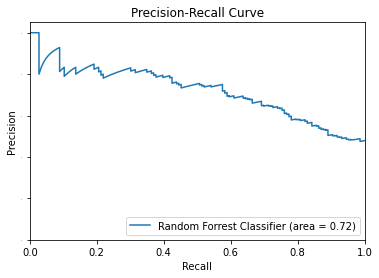

In [83]:
# Grid search for hyperparameters
# Random forest with Recursive feature elimination
rfcv = RFECV(estimator=RandomForestClassifier(random_state = 42))
rfcv.fit(X_train, y_train)
rf_feature = X_train.columns[rfcv.support_]
rfc=RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train[rf_feature], y_train)
y_pred_rf = CV_rfc.predict(X_test[rf_feature])
print ('best parameter: ', CV_rfc.best_params_)
print (len(rf_feature), 'selected features')
plot_AUC(CV_rfc, X_test[rf_feature], y_test)

In [88]:
# selected features
print (len(rf_feature), 'selected features:\n', list(rf_feature))

48 selected features:
 ['days_create2Trial', 'goal_running.health', 'goal_running.injury', 'goal_running.other', 'goal_running.race', 'exp_beginner', 'exp_experienced', 'exp_intermediate', 'b4Trial_ActivityComplete_norm', 'b4Trial_ActivityComplete_ave', 'b4Trial_SessionCompleted_ave', 'b4Trial_SessionCompleted_freq', 'b4Trial_LibrarySelectedTab_norm', 'b4Trial_LibrarySelectedTab_ave', 'b4Trial_LibrarySelectedTab_freq', 'b4Trial_ScreenViewed_norm', 'b4Trial_ScreenViewed_ave', 'b4Trial_ScreenViewed_freq', 'b4Trial_AppForeground_norm', 'b4Trial_AppForeground_ave', 'b4Trial_AppForeground_freq', 'b4Trial_SessionViewed_norm', 'b4Trial_SessionViewed_ave', 'b4Trial_SessionViewed_freq', '7dTrial_ActivityComplete_cons', '7dTrial_ActivityComplete_freq', '7dTrial_SessionCompleted_cons', '7dTrial_SessionCompleted_freq', '7dTrial_LibrarySelectedTab_cons', '7dTrial_LibrarySelectedTab_freq', '7dTrial_ScreenViewed_cons', '7dTrial_ScreenViewed_freq', '7dTrial_AppForeground_cons', '7dTrial_AppForeground_

## 8. Interpreting the model

In [90]:
rf=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 100, max_depth=8, criterion='gini', oob_score = True)
selector = rf.fit(X_train[rf_feature], y_train)

Weight,Feature
0.0186 ± 0.0174,7dTrial_SessionCompleted_freq
0.0154 ± 0.0131,b4Trial_ScreenViewed_freq
0.0141 ± 0.0087,2dTrial_SessionViewed_freq
0.0135 ± 0.0095,2dTrial_SessionCompleted_freq
0.0122 ± 0.0125,7dTrial_LibrarySelectedTab_freq
0.0116 ± 0.0032,2dTrial_ActivityComplete_freq
0.0116 ± 0.0132,2dTrial_ScreenViewed_freq
0.0103 ± 0.0303,7dTrial_SessionViewed_freq
0.0096 ± 0.0129,7dTrial_SessionViewed_cons
0.0084 ± 0.0032,2dTrial_LibrarySelectedTab_freq


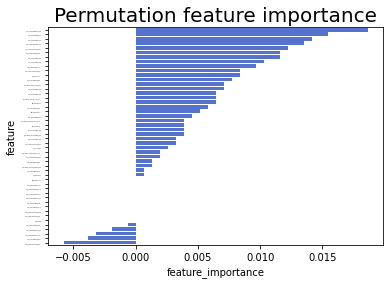

In [91]:
perm = PermutationImportance(rf, random_state=1).fit(X_test[rf_feature], y_test)
perm_imp_eli5 = imp_df(list(rf_feature), perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance', y_sz=1)
eli5.show_weights(perm, feature_names = list(rf_feature))

Top 20 most important features


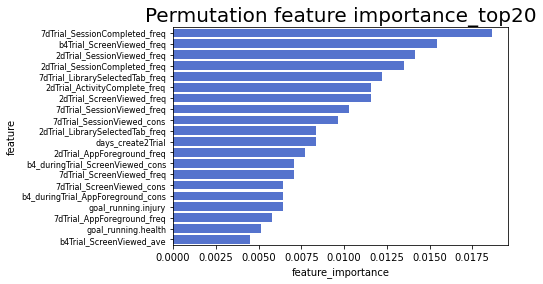

In [94]:
print ('Top 20 most important features')
var_imp_plot(perm_imp_eli5.head(20), 'Permutation feature importance_top20', y_sz=8)

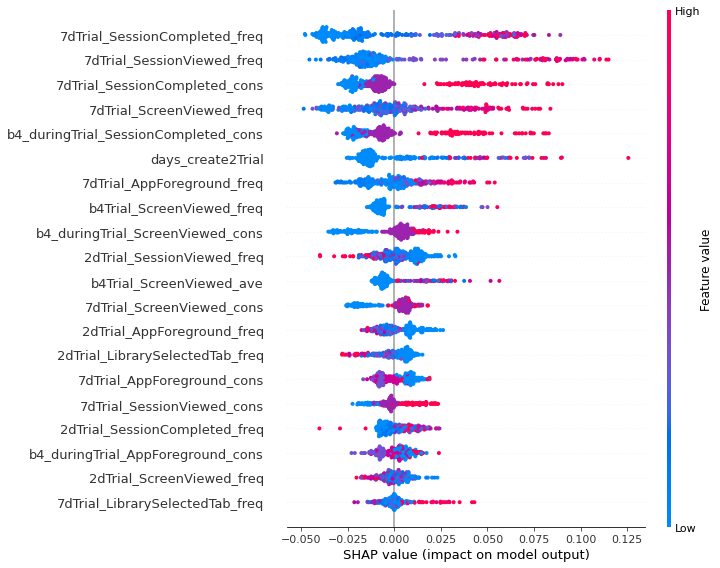

In [95]:
shap.initjs()
explainer = shap.TreeExplainer(selector)
shap_values = explainer.shap_values(X_test[rf_feature])
f = plt.figure()
shap.summary_plot(shap_values[1], X_test[rf_feature])
f.savefig('../results/shap.png', bbox_inches='tight', dpi=600)

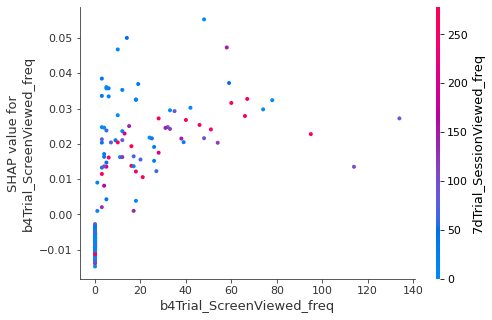

In [96]:
# Feature dependence plot: an interactions of 2 features on prediction
shap.dependence_plot('b4Trial_ScreenViewed_freq', shap_values[1], X_test[rf_feature], interaction_index="7dTrial_SessionViewed_freq")

In [97]:
# explore samples by features
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test[rf_feature])

In [98]:
### to save the plot by matplotlib, uncomment the following statements ###
# plt.clf()
# shap.initjs()
instance_to_explain = 258
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_to_explain], 
                X_test[rf_feature].iloc[instance_to_explain])#, matplotlib=True,show=False)
# plt.savefig('../results/shap_eg1.png', dpi=600, transparent = True)

In [ ]:
### save datafranes ###
# X.to_csv('../results/X')
# y.to_csv('../results/y')